### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 10 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 10 мая, -4 балла после 08:30 17 мая, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Ваше решение тут

1) MSE: $$  -\frac{\partial L(a(x_i), y_i)}{\partial a(x_i)} = -\frac{\partial  (y_i - a(x_i)) ^ 2}{\partial a(x_i)} = 2(y_i - a(x_i)) $$

2) Экспоненциальный таргет: $$  -\frac{\partial L(a(x_i), y_i)}{\partial a(x_i)} = -\frac{\partial  (exp( -a(x_i) y_i))}{\partial a(x_i)} = y_iexp(-a(x_i)y_i) $$

3) Логистический таргет: $$  -\frac{\partial L(a(x_i), y_i)}{\partial a(x_i)} = -\frac{\partial  \log (1 + exp( -a(x_i) y_i))}{\partial a(x_i)} = 
    \frac{y_i}{1 +  exp(a(x_i) y_i)}$$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [1]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

In [2]:
class MyGradientBoostingClassifier:

    def __init__(self, loss='mse', learning_rate=0.1, n_estimators=100, colsample=1.0, subsample=1.0, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        colsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs
    
    def calc_loss(self, y, a):
        if self.loss == 'mse':
            return 2 * (y - a)
        elif self.loss == 'exp':
            return y * np.exp(-y * a)
        elif self.loss == 'log':
            return y / (np.exp(a*y) + 1)
    
    def fit(self, X, y,  base_model = DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        self.info = dict()
        total_objects = X.shape[0]
        total_features = X.shape[1]
        used_objects = int(np.floor(self.subsample * total_objects))
        used_features = int(np.floor(self.colsample * total_features))
        if init_model is not None:
            self.init_model = init_model()
            self.init_model.fit(X, y)
            self.fk = self.init_model.predict(X)
        else:
            self.init_model = None
            self.fk = np.ones(total_objects)/total_objects
        for i in range(0, self.n_estimators):
            cur_used_features = np.random.choice(total_features, used_features)
            cur_used_objects = np.random.choice(total_objects, total_objects)
            cur_model = base_model(*self.args, **self.kwargs)
            used_X = X[cur_used_objects,:][:, cur_used_features]
            used_for_pred_X = X[:,:][:, cur_used_features]
            used_y = y[cur_used_objects]
            used_fk = self.fk[cur_used_objects]
            cur_los = self.calc_loss(used_y, used_fk)
            cur_model.fit(used_X, cur_los)
            self.fk = self.fk + self.learning_rate * cur_model.predict(used_for_pred_X)
            self.info[i] = dict()
            self.info[i][0] = cur_model
            self.info[i][1] = cur_used_features
        
    def predict(self, X):
        if self.init_model is not None:
            res = self.init_model.predict(X)
        else:
            res = np.ones(X.shape[0])/X.shape[0]
        for i in range(len(self.info)):
            used_X = X[:,:][:, self.info[i][1]]
            temp = self.info[i][0].predict(used_X)
            temp = temp * self.learning_rate
            res = res + temp
        return np.around(res).astype('int')

In [3]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [4]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [5]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.8888888888888888
0.8888888888888888


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [6]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [7]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [8]:
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')
num_est = [5*i for i in np.arange(1, 11)]
from sklearn.model_selection import KFold
skf = KFold(n_splits=5, shuffle=True)

In [9]:
results =[]
for elem in tqdm_notebook(num_est):
    res = 0.0
    for train, test in skf.split(X, y):
        my_clf1 = MyGradientBoostingClassifier(n_estimators=elem)
        my_clf1.fit(X[train], y[train])
        temp = my_clf1.predict(X[test])
        res = res + accuracy_score(y[test], temp)
    print(res/5.0)
    results.append(res/5.0)

0.8169089147286821
0.8624515503875969
0.8647286821705427
0.8688953488372093
0.8651162790697674
0.8815891472868216
0.870203488372093
0.8781492248062015
0.8775678294573643
0.8659399224806201



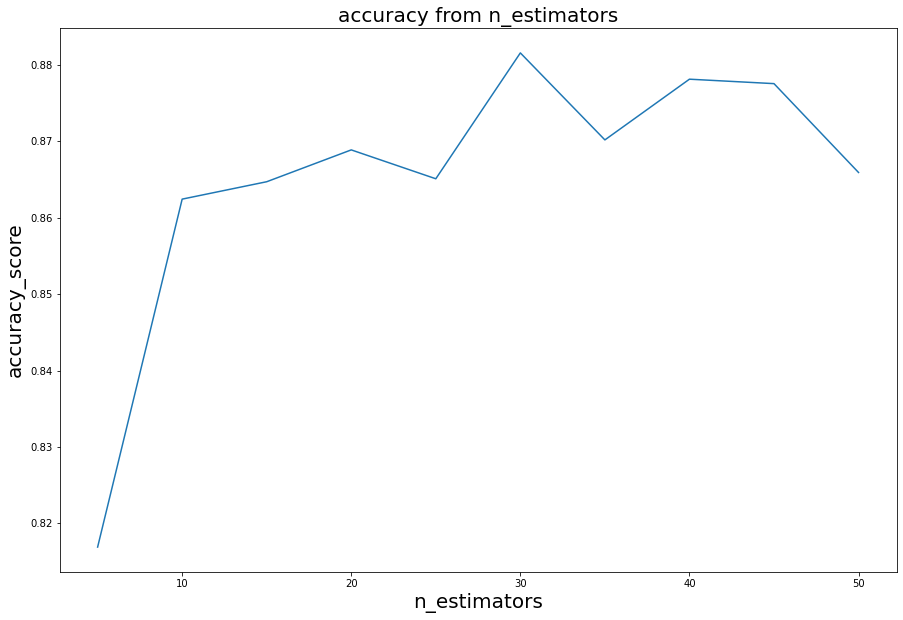

In [10]:
plt.figure(figsize=(15,10))
plt.title("accuracy from n_estimators", fontsize = 20)
plt.xlabel("n_estimators", fontsize = 20)
plt.ylabel("accuracy_score", fontsize = 20)
plt.plot(num_est, results)
plt.show()

In [11]:
help1 = results.index(max(results))
best_est = num_est[help1]

In [12]:
best_est

30

В целях экономии времени при валидации, ограничим число n_estimators:

In [13]:
best_est = 15

In [14]:
loss = ['mse', 'exp','log']
learn = [0.05, 0.1, 0.2]
colsample = [0.5, 0.75, 1.0]
subsample = [0.5, 0.75, 1.0]
best_score = 0
best_params = dict()
best_params['loss'] = None
best_params['learning_rate'] = None
best_params['n_estimators'] = best_est
best_params['colsample'] = None
best_params['subsample'] = None

In [15]:
ind = 0
for loss1 in loss:
    for learn1 in learn:
        for colsample1 in colsample:
            for subsample1 in subsample:
                res = 0.0
                ind+=1
                for train, test in skf.split(X, y):
                    my_clf1 = MyGradientBoostingClassifier(loss=loss1, learning_rate=learn1, 
                                                        n_estimators=best_est,
                                                        colsample=colsample1, 
                                                        subsample=subsample1)
                    my_clf1.fit(X[train], y[train])
                    temp = my_clf1.predict(X[test])
                    res = res + accuracy_score(y[test], temp)
                print(res/5.0, " ", ind)
                if (res/5.0) > best_score:
                    best_score = res/5.0
                    best_params['loss'] = loss1
                    best_params['learning_rate'] = learn1
                    best_params['colsample'] = colsample1
                    best_params['subsample'] = subsample1
                print(best_score)
                print(best_params)

0.8174418604651162   1
0.8174418604651162
{'loss': 'mse', 'learning_rate': 0.05, 'n_estimators': 15, 'colsample': 0.5, 'subsample': 0.5}
0.831734496124031   2
0.831734496124031
{'loss': 'mse', 'learning_rate': 0.05, 'n_estimators': 15, 'colsample': 0.5, 'subsample': 0.75}
0.8235465116279072   3
0.831734496124031
{'loss': 'mse', 'learning_rate': 0.05, 'n_estimators': 15, 'colsample': 0.5, 'subsample': 0.75}
0.8593507751937984   4
0.8593507751937984
{'loss': 'mse', 'learning_rate': 0.05, 'n_estimators': 15, 'colsample': 0.75, 'subsample': 0.5}
0.8551841085271319   5
0.8593507751937984
{'loss': 'mse', 'learning_rate': 0.05, 'n_estimators': 15, 'colsample': 0.75, 'subsample': 0.5}
0.8474321705426355   6
0.8593507751937984
{'loss': 'mse', 'learning_rate': 0.05, 'n_estimators': 15, 'colsample': 0.75, 'subsample': 0.5}
0.8634205426356589   7
0.8634205426356589
{'loss': 'mse', 'learning_rate': 0.05, 'n_estimators': 15, 'colsample': 1.0, 'subsample': 0.5}
0.8585271317829456   8
0.86342054263565

0.5780523255813954   61
0.8825096899224805
{'loss': 'exp', 'learning_rate': 0.1, 'n_estimators': 15, 'colsample': 1.0, 'subsample': 0.75}
0.5780523255813954   62
0.8825096899224805
{'loss': 'exp', 'learning_rate': 0.1, 'n_estimators': 15, 'colsample': 1.0, 'subsample': 0.75}
0.5780523255813954   63
0.8825096899224805
{'loss': 'exp', 'learning_rate': 0.1, 'n_estimators': 15, 'colsample': 1.0, 'subsample': 0.75}
0.7445736434108526   64
0.8825096899224805
{'loss': 'exp', 'learning_rate': 0.1, 'n_estimators': 15, 'colsample': 1.0, 'subsample': 0.75}
0.7486918604651163   65
0.8825096899224805
{'loss': 'exp', 'learning_rate': 0.1, 'n_estimators': 15, 'colsample': 1.0, 'subsample': 0.75}
0.7390988372093024   66
0.8825096899224805
{'loss': 'exp', 'learning_rate': 0.1, 'n_estimators': 15, 'colsample': 1.0, 'subsample': 0.75}
0.7855135658914729   67
0.8825096899224805
{'loss': 'exp', 'learning_rate': 0.1, 'n_estimators': 15, 'colsample': 1.0, 'subsample': 0.75}
0.7901647286821707   68
0.88250968

Результаты, полученные на валидации

In [16]:
best_params

{'loss': 'exp',
 'learning_rate': 0.1,
 'n_estimators': 15,
 'colsample': 1.0,
 'subsample': 0.75}

In [17]:
best_score

0.8825096899224805

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [18]:
from sklearn.ensemble import RandomForestRegressor
res = 0.0
for train, test in skf.split(X, y):
    my_clf1 = MyGradientBoostingClassifier(**best_params)
    my_clf1.fit(X[train], y[train], base_model = RandomForestRegressor)
    temp = my_clf1.predict(X[test])
    res = res + accuracy_score(y[test], temp)
    print(accuracy_score(y[test], temp))
print("BooBag result: ", res/5.0)

0.9001937984496124
0.8825096899224806
0.8965600775193798
0.8783914728682171
0.9004360465116279
BooBag result:  0.8916182170542637


In [19]:
res = 0.0
N = 50
for train, test in skf.split(X, y):
    res1 = 0
    for i in tqdm_notebook(range(N)):
        my_clf1 = MyGradientBoostingClassifier(**best_params)
        obj = np.random.choice(X[train].shape[0], X[train].shape[0] // N)
        my_clf1.fit(X[train][obj], y[train][obj])
        temp = my_clf1.predict(X[test])
        res1 = res1 + temp
    res1 = res1 / N
    resN = np.around(res1).astype('int')
    res = res + accuracy_score(y[test], resN)
print("BagBoo result: ", res/5.0)


BagBoo result:  0.8526647286821705


При использовании Random Forest в качестве базовой модели скор увеличился - Random Forest лучше адаптируется под данные.
BagBoo не улучшил результаты, возможно, для него необходимо отдельно подбирать параметры на валидации.

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [20]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [21]:
res = 0.0
for train, test in skf.split(X, y):
    my_clf1 = MyGradientBoostingClassifier()
    my_clf1.fit(X[train], y[train], init_model = LinearRegression)
    temp = my_clf1.predict(X[test])
    res = res + accuracy_score(y[test], temp)
    print(accuracy_score(y[test], temp))
print("Score LinearRegression: ", res/5.0)

0.8827519379844961
0.8846899224806202
0.8921996124031008
0.8733042635658915
0.8834786821705426
Score LinearRegression:  0.8832848837209303


In [22]:
res = 0.0
for train, test in skf.split(X, y):
    my_clf1 = MyGradientBoostingClassifier()
    my_clf1.fit(X[train], y[train], init_model = LogisticRegression)
    temp = my_clf1.predict(X[test])
    res = res + accuracy_score(y[test], temp)
    print(accuracy_score(y[test], temp))
print("Score LogisticRegression: ", res/5.0)

0.8396317829457365
0.8299418604651163
0.8316375968992248
0.8217054263565892
0.8238856589147286
Score LogisticRegression:  0.8293604651162791


In [23]:
res = 0.0
for train, test in skf.split(X, y):
    my_clf1 = MyGradientBoostingClassifier()
    my_clf1.fit(X[train], y[train], init_model = DecisionTreeRegressor)
    temp = my_clf1.predict(X[test])
    res = res + accuracy_score(y[test], temp)
    print(accuracy_score(y[test], temp))
print("Score DecisionTreeRegressor: ", res/5.0)

0.8374515503875969
0.8328488372093024
0.8284883720930233
0.8318798449612403
0.844718992248062
Score DecisionTreeRegressor:  0.835077519379845


In [24]:
res = 0.0
for train, test in skf.split(X, y):
    my_clf1 = MyGradientBoostingClassifier()
    my_clf1.fit(X[train], y[train], init_model = DecisionTreeClassifier)
    temp = my_clf1.predict(X[test])
    res = res + accuracy_score(y[test], temp)
    print(accuracy_score(y[test], temp))
print("Score DecisionTreeClassifier: ", res/5.0)

0.8318798449612403
0.8323643410852714
0.8357558139534884
0.8287306201550387
0.8355135658914729
Score DecisionTreeClassifier:  0.8328488372093024


In [25]:
res = 0.0
for train, test in skf.split(X, y):
    my_clf1 = MyGradientBoostingClassifier()
    my_clf1.fit(X[train], y[train], init_model = SGDClassifier)
    temp = my_clf1.predict(X[test])
    res = res + accuracy_score(y[test], temp)
    print(accuracy_score(y[test], temp))
print("Score SGDClassifier: ", res/5.0)

0.8069282945736435
0.8502906976744186
0.8040213178294574
0.8231589147286822
0.8204941860465116
Score SGDClassifier:  0.8209786821705427


In [26]:
res = 0.0
for train, test in skf.split(X, y):
    my_clf1 = MyGradientBoostingClassifier()
    my_clf1.fit(X[train], y[train], init_model = LinearSVC)
    temp = my_clf1.predict(X[test])
    res = res + accuracy_score(y[test], temp)
    print(accuracy_score(y[test], temp))
print("Score LinearSVC: ", res/5.0)

0.8459302325581395
0.8548934108527132
0.7877906976744186
0.8250968992248062
0.7902131782945736
Score LinearSVC:  0.8207848837209302


In [27]:
res = 0.0
for train, test in skf.split(X, y):
    my_clf1 = MyGradientBoostingClassifier()
    my_clf1.fit(X[train], y[train], init_model = SVC)
    temp = my_clf1.predict(X[test])
    res = res + accuracy_score(y[test], temp)
    print(accuracy_score(y[test], temp))
print("Score SVC: ", res/5.0)

0.8657945736434108
0.8791182170542635
0.875484496124031
0.8817829457364341
0.8689437984496124
Score SVC:  0.8742248062015502


In [28]:
res = 0.0
for train, test in skf.split(X, y):
    my_clf1 = MyGradientBoostingClassifier()
    my_clf1.fit(X[train], y[train], init_model = RandomForestRegressor)
    temp = my_clf1.predict(X[test])
    res = res + accuracy_score(y[test], temp)
    print(accuracy_score(y[test], temp))
print("Score RandomForestRegressor: ", res/5.0)

0.8856589147286822
0.8931686046511628
0.8868701550387597
0.8800872093023255
0.8885658914728682
Score RandomForestRegressor:  0.8868701550387599


In [29]:
res = 0.0
for train, test in skf.split(X, y):
    my_clf1 = MyGradientBoostingClassifier()
    my_clf1.fit(X[train], y[train], init_model = RandomForestClassifier)
    temp = my_clf1.predict(X[test])
    res = res + accuracy_score(y[test], temp)
    print(accuracy_score(y[test], temp))
print("Score RandomForestClassifier: ", res/5.0)

0.8849321705426356
0.8905038759689923
0.8842054263565892
0.8892926356589147
0.8924418604651163
Score RandomForestClassifier:  0.8882751937984497


Качество решения при использовании RandomForestClassifier улучшилось - модель дает в начале более точное решение, проще исправлять ошибки на следующих итерациях

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

